In [1]:
!pip install transformers==4.41.1
!pip install sentencepiece
!pip install accelerate
!pip install torch
!pip install datasets evaluate
!pip install -U bitsandbytes
!pip install huggingface_hub
!pip install peft==0.5.0
!pip install trl
!pip install loguru
!pip install --upgrade peft
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [2]:
import json
import re
import os
import random
import pandas as pd
import numpy as np
import plotly.express as px
import torch
import datasets
import evaluate
from loguru import logger
from tqdm import tqdm
from datasets import load_dataset, load_from_disk, Dataset, DatasetDict
from transformers import (AutoModelForSequenceClassification,
                          AutoTokenizer,
                          AutoModelForCausalLM,
                          BitsAndBytesConfig,
                          pipeline,
                          logging,
                          DataCollatorWithPadding)
from transformers import TrainingArguments, Trainer
from trl import SFTTrainer
from trl import setup_chat_format
from peft.utils import TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

## Dataset Financial Relation Extraction Instruction

In [3]:
dataset = load_dataset("FinGPT/fingpt-finred-cls")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/623 [00:00<?, ?B/s]

(…)-00000-of-00001-cae87f8e074b4b5d.parquet:   0%|          | 0.00/2.43M [00:00<?, ?B/s]

(…)-00000-of-00001-907283975ba983af.parquet:   0%|          | 0.00/466k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/48474 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8928 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 48474
    })
    test: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 8928
    })
})

## Modèle de machine Learning classique (SVM, RandomForestClassifier, LogReg)

In [4]:
# Converter dataset to Pandas dataframe
def convert_to_pandas(dataset):
    dataset = dataset.to_pandas()
    dataset = dataset.sample(frac=1).reset_index(drop=True)
    return dataset

In [5]:
dataset_train = convert_to_pandas(dataset['train'])
dataset_test = convert_to_pandas(dataset['test'])
df = pd.concat([dataset_train, dataset_test])
df.shape

(57402, 3)

In [6]:
df.head()

,input,output,instruction
0,(Reuters) - Warren Buffett's Berkshire Hathawa...,owner of,Take context from the input text and decide on...
1,The Deloitte report also advocated cutting the...,product/material produced,"In the context of the input sentence, determin..."
2,"Himani Chandna, Hindustan Times , New Delhi | ...",headquarters location,What is the relationship between 'Hindustan Ti...
3,** The entertainment arm of Chinese property c...,location of formation,Take context from the input text and decide on...
4,Freeport-McMoRan controls 53.56 percent of Cer...,industry,What is the relationship between 'Buenaventura...


In [7]:
len(df.output.value_counts())

29

In [8]:
id2label = {idx:label for idx, label in enumerate(df.output.unique())}
label2id = {label:idx for idx, label in enumerate(df.output.unique())}

df["labels_cat"] = df["output"].map(lambda x : label2id[x])

label_counts = df['labels_cat'].value_counts()
percentages = (label_counts / len(df)) * 100

fig = px.histogram(df, x="labels_cat", color="output", title="Distribution des étiquettes dans les données pour la tâche de l'extraction de relation.")
fig.update_layout(yaxis_title="value_counts")
fig.update_layout(bargap=0.2)
fig.update_layout(bargroupgap=0.1)

fig.show()

In [ ]:
data = df[["input", "labels_cat"]]
data.head()

,input,labels_cat
0,If you run out for coffee and forget your wall...,0
1,Mobile apps such as CouponSherpa and RetailMeN...,1
2,Germany and other eurozone leaders handed Gree...,2
3,"As news of Iwata's death spread online, condol...",3
4,Some of the faster growing parts of our busine...,4


In [ ]:
# Remove stopwords and ponctuation(url, ?, "", , etc...)
def remove_stopwords_and_ponctuation(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

data["input"] = data["input"].apply(remove_stopwords_and_ponctuation)
data.head()

<ipython-input-10-24841086aa16>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,input,labels_cat
0,If you run out for coffee and forget your wall...,0
1,Mobile apps such as CouponSherpa and RetailMeN...,1
2,Germany and other eurozone leaders handed Gree...,2
3,As news of Iwatas death spread online condolen...,3
4,Some of the faster growing parts of our busine...,4


## Split les données (training 70%, validation 10% et testing 20%)

In [ ]:
# Splitting data into X_train, y_train, X_val, y_val, X_test, y_test
X_train, X_test, y_train, y_test = train_test_split(data["input"], data["labels_cat"], train_size=0.8, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.875, random_state=42)
print(f"Train size: {round(len(X_train)/len(data) * 100, 1)}%")
print(f"Validation size: {round(len(X_val) / len(data) * 100, 1)}%")
print(f"Test size: {round(len(X_test) / len(data) * 100, 1)}%")

Train size: 70.0%
Validation size: 10.0%
Test size: 20.0%


In [ ]:
# Vectorisation des données d'entrée
vectoizer = TfidfVectorizer()
X_train_vec = vectoizer.fit_transform(X_train)
X_val_vec = vectoizer.transform(X_val)
X_test_vec = vectoizer.transform(X_test)
X_train_vec.shape, X_val_vec.shape, X_test_vec.shape

((40180, 24396), (5741, 24396), (11481, 24396))

## Tester les modèles de Machine Learning (SVM, logReg, RFC)

In [ ]:
models = {
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier()
}

precisions = {}
recalls = {}
f1_scores = {}

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    print("-"*100)
    print(name)
    print("Accuracy score: ", accuracy_score(y_val, model.predict(X_val_vec)))
    print("Precision score: ", precision_score(y_val, model.predict(X_val_vec), average='macro'))
    print("Recall score: ", recall_score(y_val, model.predict(X_val_vec), average='macro'))
    print("F1 score: ", f1_score(y_val, model.predict(X_val_vec), average='macro'))
    precisions[name] = precision_score(y_val, model.predict(X_val_vec), average='macro')
    recalls[name] = recall_score(y_val, model.predict(X_val_vec), average='macro')
    f1_scores[name] = f1_score(y_val, model.predict(X_val_vec), average='macro')

----------------------------------------------------------------------------------------------------
SVM
Accuracy score:  0.7023166695697614
Precision score:  0.7137928888885781
Recall score:  0.6792310424259614
F1 score:  0.687130366568944


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



----------------------------------------------------------------------------------------------------
Logistic Regression
Accuracy score:  0.6937815711548511
Precision score:  0.7138181725219155
Recall score:  0.6384706185119481
F1 score:  0.6612001975259895
----------------------------------------------------------------------------------------------------
Random Forest
Accuracy score:  0.7051036404807525
Precision score:  0.703806957299707
Recall score:  0.6993161965843684
F1 score:  0.6986643009853685


In [ ]:
print(f"F1-score de SVC : {f1_score(y_test, models['SVM'].predict(X_test_vec), average='macro')}")
print(f"F1-score de Logistic Regression : {f1_score(y_test, models['Logistic Regression'].predict(X_test_vec), average='macro')}")
print(f"F1-score de Random Forest : {f1_score(y_test, models['Random Forest'].predict(X_test_vec), average='macro')}")

F1-score de SVC : 0.6914342810590589
F1-score de Logistic Regression : 0.655521108369058
F1-score de Random Forest : 0.6962967604879525


In [ ]:
from sklearn.metrics import classification_report

# y_test correspond aux vraies étiquettes et y_pred aux prédictions du modèle
print("SVM")
print(classification_report(y_test,  models['SVM'].predict(X_test_vec)))
print("-"*100)
print("Logistic Regression")
print(classification_report(y_test,  models['Logistic Regression'].predict(X_test_vec)))
print("-"*100)
print("Random Forest")
print(classification_report(y_test,  models['Random Forest'].predict(X_test_vec)))

SVM
              precision    recall  f1-score   support

           0       0.62      0.43      0.51       317
           1       0.89      0.90      0.90      1582
           2       0.85      0.89      0.87      1877
           3       0.78      0.61      0.68       333
           4       0.40      0.46      0.43      1003
           5       0.51      0.56      0.53       120
           6       0.48      0.44      0.46       772
           7       0.95      0.89      0.92       238
           8       0.55      0.20      0.29        92
           9       0.63      0.70      0.66       362
          10       0.82      0.81      0.82       863
          11       0.34      0.38      0.36       223
          12       0.86      0.85      0.86       216
          13       0.50      0.42      0.45       535
          14       0.59      0.55      0.57       130
          15       0.60      0.49      0.54       279
          16       0.90      0.85      0.88        75
          17       0.85

In [ ]:
# Matrice des confusions
print("SVM")
print(confusion_matrix(y_test, models['SVM'].predict(X_test_vec)))
print("-"*100)
print("Logistic Regression")
print(confusion_matrix(y_test, models['Logistic Regression'].predict(X_test_vec)))
print("-"*100)
print("Random Forest")
print(confusion_matrix(y_test, models['Random Forest'].predict(X_test_vec)))

## Modèle de BERT

In [9]:
dataframe = df[["instruction","input", "output"]]
dataframe['labels'] = dataframe["output"].map(lambda x : label2id[x])
dataframe.head()

,instruction,input,output,labels
0,Take context from the input text and decide on...,(Reuters) - Warren Buffett's Berkshire Hathawa...,owner of,0
1,"In the context of the input sentence, determin...",The Deloitte report also advocated cutting the...,product/material produced,1
2,What is the relationship between 'Hindustan Ti...,"Himani Chandna, Hindustan Times , New Delhi | ...",headquarters location,2
3,Take context from the input text and decide on...,** The entertainment arm of Chinese property c...,location of formation,3
4,What is the relationship between 'Buenaventura...,Freeport-McMoRan controls 53.56 percent of Cer...,industry,4


In [10]:
# Reconvertir Pandas dataframe en format de datasets de HuggingFace
dataframe = dataframe.drop(columns=["output"])
dataframe = datasets.Dataset.from_pandas(dataframe)

In [11]:
training, testing = dataframe.train_test_split(train_size=0.8, shuffle=True, seed=42).values()
training, validation = training.train_test_split(train_size=0.875, shuffle=True, seed=42).values()
print(f"Training size: {round(len(training) / len(dataframe) * 100, 1)}%")
print(f"Validation size: {round(len(validation) / len(dataframe) * 100, 1)}%")
print(f"Testing size: {round(len(testing) / len(dataframe) * 100, 1)}%")

Training size: 70.0%
Validation size: 10.0%
Testing size: 20.0%


##  Chargez le modèle Pré-entrainé de BERT et le AutoTokenizer

In [12]:
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=29, id2label=id2label, label2id=label2id)
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
# Create a function tokenizer
def tokenize_function(examples):
    # Extract the instruction and inputs from the examples
    inputs =  [f"""
                {instruction}

                [{input}]

            """.strip() for instruction, input in zip(examples["instruction"], examples["input"])]
    # Tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        inputs,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="np"
    )
    return tokenized_inputs

In [14]:
# Ajout pad token si none exists
if tokenizer.pad_token is None:
  tokenizer.add_special_tokens({"pad_token": "[PAD]"})
  model.resize_token_embeddings(len(tokenizer))

# tokenize training and validation dataset
tokenize_train = training.map(tokenize_function, batched=True)
tokenize_val = validation.map(tokenize_function, batched=True)
tokenize_test = testing.map(tokenize_function, batched=True)

Map:   0%|          | 0/40180 [00:00<?, ? examples/s]

Map:   0%|          | 0/5741 [00:00<?, ? examples/s]

Map:   0%|          | 0/11481 [00:00<?, ? examples/s]

In [15]:
# Evaluation métriques
accuracy = evaluate.load("accuracy")
# Créer une fonction d'évaluation
def compute_metrics(p):
  predictions, labels = p
  predictions = np.argmax(predictions, axis=1)
  return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

In [16]:
# créer un data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Fine-tune BERT

In [17]:
# Fine tuner avec LoRA(Low Rank Adaption
peft_config = LoraConfig(task_type="SEQ_CLS",
                         r=64,
                         lora_alpha=32,
                         lora_dropout=0.01,
                         target_modules=["query"])

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 1,201,949 || all params: 110,706,490 || trainable%: 1.0857


In [24]:
# Hyperparamétres
lr = 2e-4
batch_size = 4
num_epochs = 2

# Créer un training arugments
training_args = TrainingArguments(
    output_dir="./Fine-tuned-Bert-base-uncased-lora-financial-Relation-Extraction-cls",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    num_train_epochs=num_epochs,
    )

In [25]:
# Créer un objet trainer pour l'entrainement
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenize_train,
    eval_dataset=tokenize_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics)
trainer.train()

<ipython-input-25-841bf78fc8e5>:2: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
500,2.622000
1000,1.898000
1500,1.551300
2000,1.346300
2500,1.144100
3000,1.076100
3500,0.980200
4000,0.917200
4500,0.896000
5000,0.799100


TrainOutput(global_step=20090, training_loss=0.6769323069874833, metrics={'train_runtime': 5925.2319, 'train_samples_per_second': 13.562, 'train_steps_per_second': 3.391, 'total_flos': 2.144545033150464e+16, 'train_loss': 0.6769323069874833, 'epoch': 2.0})

## Sauvegarder le modèle BERT

In [41]:
# Connexion huggingface
from huggingface_hub import notebook_login
notebook_login()

In [42]:
# Enregistrer le modèle
trainer.save_model("./drive/MyDrive/Fine-tuned-Bert-base-uncased-lora-financial-Relation-Extraction-cls")
# Sauvegarder le modèle dans huggingface
trainer.push_to_hub()

adapter_model.safetensors:   0%|          | 0.00/4.81M [00:00<?, ?B/s]

events.out.tfevents.1745233094.22c1d65c85e6.721.1:   0%|          | 0.00/6.69k [00:00<?, ?B/s]

events.out.tfevents.1745233152.22c1d65c85e6.721.2:   0%|          | 0.00/6.69k [00:00<?, ?B/s]

events.out.tfevents.1745233246.22c1d65c85e6.721.3:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/OsmanDji/Fine-tuned-Bert-base-uncased-lora-financial-Relation-Extraction-cls/commit/7ba0bddbb39923b60b2e15452fe6c7c2a57d55e3', commit_message='End of training', commit_description='', oid='7ba0bddbb39923b60b2e15452fe6c7c2a57d55e3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/OsmanDji/Fine-tuned-Bert-base-uncased-lora-financial-Relation-Extraction-cls', endpoint='https://huggingface.co', repo_type='model', repo_id='OsmanDji/Fine-tuned-Bert-base-uncased-lora-financial-Relation-Extraction-cls'), pr_revision=None, pr_num=None)

In [33]:
print(f"Text : {tokenize_test[['instruction', 'input'][0]]}")
inputs = tokenizer(tokenize_test["input"][0], return_tensors="pt").to(model.device) # Move inputs to the same device as the model
inputs

Text : ["Refer to the input text as context and select the correct relationship between 'fresh' and 'retail' from the available options.\nOptions: developer, business division, industry, publisher", "Take context from the input text and decide on the accurate relationship between 'Berkshire Hathaway' and 'Insurance' from the options provided.\nOptions: owned by, brand, industry, chief executive officer", "Utilize the input text as a context reference, choose the right relationship between 'Saipem' and 'Milan' from the options.\nOptions: headquarters location, publisher, brand, subsidiary", "Refer to the input text as context and select the correct relationship between 'Buick Encore' and 'Buick' from the available options.\nOptions: developer, parent organization, brand, subsidiary", "Refer to the input text as context and select the correct relationship between 'Lloyd Blankfein' and 'Chief Executive Officer' from the available options.\nOptions: developer, employer, distributed by, pos

{'input_ids': tensor([[  101,  2045,  2003,  4840, 12143,  2008,  1996,  2833,  7027,  4753,
          2003,  2055,  2000,  2227,  1037,  2047,  4400,  1997,  3976,  7659,
          1010,  1998,  2008,  9959,  2015,  2071,  5271,  2049, 15106,  5324,
          1011,  1011,  4445,  1997,  2029,  2003,  2307,  2739,  2005,  9959,
          2015,  1012,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

In [36]:
predictions = []
for i in range(len(tokenize_test)):
  # Combine instruction and input into a single string
  text = f"""
            {tokenize_test['instruction'][i]}

            [{tokenize_test['input'][i]}]

        """.strip()
  inputs = tokenizer(text, return_tensors="pt", max_length=512,
                     padding=True, truncation=True).to(model.device) # Move inputs to the same device as the model

  outputs = model(**inputs)

  predicted_class = outputs.logits.argmax().item()
  predictions.append(predicted_class)

In [37]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
print(f"Accuracy : {accuracy_score(tokenize_test['labels'], predictions)}")
print(f"Precision : {precision_score(tokenize_test['labels'], predictions, average='macro')}")
print(f"Recall : {recall_score(tokenize_test['labels'], predictions, average='macro')}")
print(f"F1-score : {f1_score(tokenize_test['labels'], predictions, average='macro')}")

Accuracy : 0.8975698980925007
Precision : 0.839307426578846
Recall : 0.7914212221265807
F1-score : 0.8028417898686107


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [38]:
from sklearn.metrics import classification_report
print("BERT Fune tuned FinRED cls")
print(classification_report(tokenize_test['labels'],  predictions))

BERT Fune tuned FinRED cls
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       693
           1       0.97      0.98      0.97      1876
           2       0.93      0.90      0.92       805
           3       0.90      0.89      0.89       327
           4       0.98      0.96      0.97      1641
           5       0.77      0.94      0.85       242
           6       0.85      0.81      0.83       320
           7       0.90      0.87      0.89       210
           8       0.83      0.92      0.87      1010
           9       0.82      0.80      0.81       128
          10       0.98      0.98      0.98       644
          11       0.87      0.96      0.91       357
          12       0.83      0.83      0.83       538
          13       0.85      0.88      0.86       792
          14       0.98      0.98      0.98       257
          15       0.81      0.68      0.74       257
          16       0.84      0.89      0.86        96


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



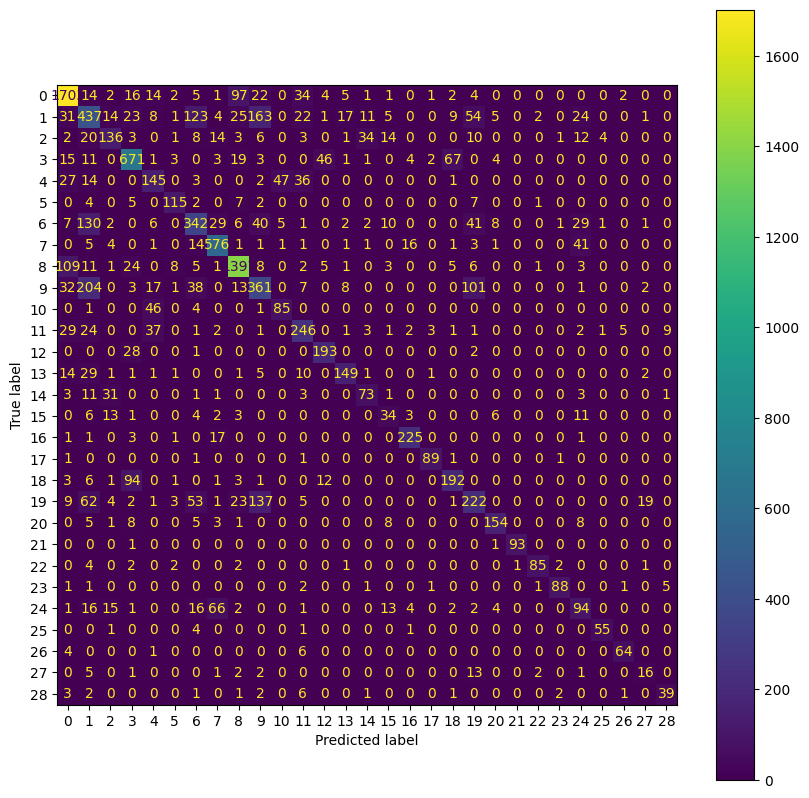

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10)) # Create a figure and axes with desired size
ConfusionMatrixDisplay(confusion_matrix(tokenize_test['labels'], predictions)).plot(ax=ax) # Plot on the axes
plt.show() # Display the plot

## Llama 3 8B Instruct

In [ ]:
dataframe = df[["input", "output", "instruction"]]

In [ ]:
training, test = train_test_split(dataframe, test_size=0.2, random_state=42)
training, val = train_test_split(training, train_size=0.9, random_state=42)

print(f"Training size: {round(len(training) / len(df), 1)*100}%")
print(f"Validation size: {round(len(val) / len(df), 1)*100}%")
print(f"Test size: { round(len(test) / len(df), 1)*100}%")

Training size: 70.0%
Validation size: 10.0%
Test size: 20.0%


In [ ]:
def create_prompt(example):
  prompt = f"""
          {example['instruction']}

          [{example['input']}] = {example['output']}
          """.strip()
  return prompt

In [ ]:
train_data = pd.DataFrame(training.apply(create_prompt, axis=1), columns=['text']).reset_index(drop=True)
val_data = pd.DataFrame(val.apply(create_prompt, axis=1), columns=['text']).reset_index(drop=True)
train_data.shape, val_data.shape

((41328, 1), (4593, 1))

In [ ]:
train_data.head()

,text
0,"Utilize the input text as a context reference,..."
1,"Utilize the input text as a context reference,..."
2,Refer to the input text as context and select ...
3,Analyze the relationship between 'out there' a...
4,"Utilize the input text as a context reference,..."


In [ ]:
train_data = datasets.Dataset.from_pandas(train_data)
val_data = datasets.Dataset.from_pandas(val_data)

In [ ]:
# Connexion HuggingFace
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map = "auto",
                                             torch_dtype = compute_dtype,
                                             quantization_config = bnb_config,
                                             trust_remote_code=True)

torch.cuda.empty_cache()
model.config.use_cache = False
model.config.pretraining_tp = 1

max_seq_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          max_seq_length=max_seq_length,
                                          use_fast=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [ ]:
peft_config = LoraConfig(
    task_type = "CAUSAL_LM",
    r = 4,
    lora_alpha = 32,
    lora_dropout = 0.01,
    bias = "none",
    target_modules = ["q_proj", "v_proj"])

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 1,703,936 || all params: 8,031,965,184 || trainable%: 0.0212


In [ ]:
training_arguments = TrainingArguments(
    output_dir="./Fine-tuned-llama3-8B-lora-financial-Relation-Extraction-cls",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    optim="paged_adamw_32bit",
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    fp16=True,
    bf16=False)

trainer = SFTTrainer(
                      model=model,
                      args=training_arguments,
                      train_dataset=train_data,
                      eval_dataset=val_data,
                      peft_config=peft_config,
                      )

Converting train dataset to ChatML:   0%|          | 0/41328 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/41328 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/41328 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/41328 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/4593 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/4593 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/4593 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/4593 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saidaliosman925 (saidaliosman925-les-crous) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,1.545900
1000,1.372900
1500,1.313300
2000,1.277900
2500,1.225900
3000,1.189600
3500,1.139400
4000,1.140500
4500,1.109200
5000,1.088400


TrainOutput(global_step=20664, training_loss=0.896830393369928, metrics={'train_runtime': 6428.0218, 'train_samples_per_second': 12.859, 'train_steps_per_second': 3.215, 'total_flos': 6.920121302130033e+17, 'train_loss': 0.896830393369928})

In [ ]:
def create_prompt_test(example):
  prompt = f"""
            {example['instruction']}

            [{example['input']}] = """.strip()
  return prompt

In [ ]:
test_data = pd.DataFrame(test.apply(create_prompt_test, axis=1),
                      columns=["text"])

In [ ]:
def predict(test, model, tokenizer):
    y_pred = []
    # Extract the merged model (base model with LoRA weights)
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
        pred = model.generate(**inputs, max_new_tokens=10, temperature=0.00000000001, pad_token_id=tokenizer.eos_token_id)
        pred_text = tokenizer.decode(pred[0], skip_special_tokens=True)
        pred = [part.strip() for part in pred_text.split("= ") if part.strip()]
        y_pred.append(pred[-1])
    return y_pred

In [ ]:
X_test = test_data
y_test = test["output"]

In [ ]:
len(X_test), len(y_test)

(11481, 11481)

In [ ]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 11481/11481 [47:34<00:00,  4.02it/s]


In [ ]:
import re
pred_label = []
n = 0
for label in y_pred:
  label = re.sub(r'\[|\]', '', label)
  if label not in id2label.values():
    print(f"Position {n} : {label}")
    pred_label.append(-1)
  else:
    pred_label.append(label2id[label])
  n+=1

Position 304 : DTS-HD Master Audio
Position 2850 : productCallCheck the relationship between 'Berger Paints
Position 9098 : stock


In [ ]:
test_label = []
for label in y_test:
  test_label.append(label2id[label])

In [ ]:
len(pred_label), len(test_label)

(11481, 11481)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
print(f"Accuracy : {accuracy_score(test_label, pred_label)}")
print(f"Precision : {precision_score(test_label, pred_label, average='macro')}")
print(f"Recall : {recall_score(test_label, pred_label, average='macro')}")
print(f"F1-score : {f1_score(test_label, pred_label, average='macro')}")

Accuracy : 0.9764828847661353
Precision : 0.9373308718796312
Recall : 0.93325027504965
F1-score : 0.9351644622431591


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [ ]:
from sklearn.metrics import classification_report
print("Llama 3 Fune tuned FinRED cls")
print(classification_report(test_label, pred_label))

Llama 3 Fune tuned FinRED cls
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.99      1.00      1.00      1873
           1       1.00      0.99      1.00      1586
           2       0.98      0.99      0.98       835
           3       0.98      0.96      0.97       366
           4       0.97      0.96      0.96       580
           5       0.98      0.94      0.96       338
           6       0.97      0.97      0.97       674
           7       0.93      0.96      0.94       993
           8       0.94      0.87      0.90        85
           9       0.97      0.94      0.96       794
          10       0.99      0.98      0.99       142
          11       1.00      1.00      1.00       640
          12       1.00      1.00      1.00        63
          13       0.94      0.94      0.94       207
          14       1.00      1.00      1.00        81
          15       0.97      0.99      0.98       3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [ ]:
prompt = X_test.iloc[304]["text"]
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
pred = model.generate(**inputs, max_new_tokens=512, temperature=0.00000000001, pad_token_id=tokenizer.eos_token_id)
pred_text = tokenizer.decode(pred[0], skip_special_tokens=True)
pred_text

"Take context from the input text and decide on the accurate relationship between 'DTS' and 'DTS-HD Master Audio' from the options provided.\nOptions: product/material produced, parent organization, distributed by, distribution format\n\n            [Street Date: October 27, 2015 Copyright: ©2015 Mattel Selection Number: 63165818 (U.S.) / 63165822 (CDN) Running time : 1 Hour 16 Minutes Layers: BD-50 Aspect Ratio: Widescreen 1.78:1 Languages/Subtitles: English, Spanish, French Sound: DTS-HD Master Audio 5.1 (English), DTS Digital Surround 5.1 (French, Spanish, Italian, German, Dutch, Portuguese)] = DTS-HD Master Audio"

In [ ]:
# Sauvegarder le modèle
trainer.save_model("./drive/MyDrive/Fine-tuned-llama3-8B-lora-financial-Relation-Extraction-cls")
# Sauvegarder le modèle dans huggingface
trainer.push_to_hub()

adapter_model.safetensors:   0%|          | 0.00/6.83M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

events.out.tfevents.1745175708.1828da476244.2650.0:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.69k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/OsmanDji/Fine-tuned-llama3-8B-lora-financial-Relation-Extraction-cls/commit/57ff64265b4e5393c7b7c1a253b01308680fc42f', commit_message='End of training', commit_description='', oid='57ff64265b4e5393c7b7c1a253b01308680fc42f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/OsmanDji/Fine-tuned-llama3-8B-lora-financial-Relation-Extraction-cls', endpoint='https://huggingface.co', repo_type='model', repo_id='OsmanDji/Fine-tuned-llama3-8B-lora-financial-Relation-Extraction-cls'), pr_revision=None, pr_num=None)

In [ ]:
def create_prompt(example):
  prompt = f"""
          {example['instruction']}

          <<SYS>>
          {example['input']}
          <</SYS>>

          Answer:

          {example['output']}

          """.strip()
  return prompt

In [ ]:
train_data = pd.DataFrame(training.apply(create_prompt, axis=1), columns=['text']).reset_index(drop=True)
val_data = pd.DataFrame(val.apply(create_prompt, axis=1), columns=['text']).reset_index(drop=True)

In [ ]:
train_data.head()

,text
0,What is the relationship between Fininvest and...
1,What is the relationship between Chevrolet Vol...
2,What is the relationship between Nissan Altima...
3,Given phrases that describe the relationship b...
4,Given phrases that describe the relationship b...


In [ ]:
train_data = datasets.Dataset.from_pandas(train_data)
val_data = datasets.Dataset.from_pandas(val_data)

In [ ]:
# Connexion HuggingFace
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map = "auto",
                                             torch_dtype = compute_dtype,
                                             quantization_config = bnb_config,
                                             trust_remote_code=True)

torch.cuda.empty_cache()
model.config.use_cache = False
model.config.pretraining_tp = 1

max_seq_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          max_seq_length=max_seq_length,
                                          use_fast=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [ ]:
peft_config = LoraConfig(
    task_type = "CAUSAL_LM",
    r = 4,
    lora_alpha = 32,
    lora_dropout = 0.01,
    bias = "none",
    target_modules = ["q_proj", "v_proj"])

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 1,703,936 || all params: 8,031,965,184 || trainable%: 0.0212


In [ ]:
train_data = train_data.shuffle(seed=42).select(range(1000))
val_data = val_data.shuffle(seed=42).select(range(100))

In [ ]:
training_arguments = TrainingArguments(
    output_dir="./Fine-tuned-llama3-8B-lora-financial-Relation-Extraction",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    learning_rate=1e-3,
    weight_decay=0.001,
    fp16=True,
    bf16=False)

trainer = SFTTrainer(
                      model=model,
                      args=training_arguments,
                      train_dataset=train_data,
                      eval_dataset=val_data,
                      peft_config=peft_config,
                      )

Converting train dataset to ChatML:   0%|          | 0/1000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/100 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saidaliosman925 (saidaliosman925-les-crous) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.732000
1000,0.449900


TrainOutput(global_step=1250, training_loss=0.5248397705078125, metrics={'train_runtime': 429.0833, 'train_samples_per_second': 11.653, 'train_steps_per_second': 2.913, 'total_flos': 6.14409144140759e+16, 'train_loss': 0.5248397705078125})

In [ ]:
# Sauvegarder le modèle
trainer.save_model("./drive/MyDrive/Fine-tuned-llama3-8B-lora-financial-Relation-Extraction")
# Sauvegarder le modèle dans huggingface
trainer.push_to_hub()

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/6.83M [00:00<?, ?B/s]

events.out.tfevents.1745093601.c3da8872777e.1800.0:   0%|          | 0.00/7.15k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.69k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/OsmanDji/Fine-tuned-llama3-8B-lora-financial-Relation-Extraction/commit/30f48674b7617bcc9e413ea5e2a798a24977dd1f', commit_message='End of training', commit_description='', oid='30f48674b7617bcc9e413ea5e2a798a24977dd1f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/OsmanDji/Fine-tuned-llama3-8B-lora-financial-Relation-Extraction', endpoint='https://huggingface.co', repo_type='model', repo_id='OsmanDji/Fine-tuned-llama3-8B-lora-financial-Relation-Extraction'), pr_revision=None, pr_num=None)

In [ ]:
def create_prompt_test(example):
  prompt = f"""
          {example['instruction']}

          <<SYS>>
          {example['input']}
          <</SYS>>

          """.strip()
  return prompt

In [ ]:
test_data = pd.DataFrame(test.apply(create_prompt_test, axis=1),
                      columns=["text"])

In [ ]:
X_test = test_data[:1000]
y_test = test["output"][:1000]

In [ ]:
X_test.head()

,text
24870,"Utilize the input text as a context reference,..."
3053,"Utilize the input text as a context reference,..."
9397,"Utilize the input text as a context reference,..."
3946,"Utilize the input text as a context reference,..."
5836,What is the relationship between classic and G...


In [ ]:
def predict(test, model, tokenizer):
    y_pred = []
    # Extract the merged model (base model with LoRA weights)
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
        pred = model.generate(**inputs, max_new_tokens=256, temperature=0.00001, pad_token_id=tokenizer.eos_token_id)
        pred_text = tokenizer.decode(pred[0], skip_special_tokens=True)
        pred = pred_text.split("Answer:")[-1]
        pred = pred.strip()
        y_pred.append(pred)
    return y_pred

In [ ]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 1000/1000 [1:28:09<00:00,  5.29s/it]


In [ ]:
y_test = y_test.to_list()

In [ ]:
def calc_metric(y_test, y_pred):
    # Initialize variables for true positives, false positives, and false negatives
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for (ground_truth, predicted_relations) in zip(y_test, y_pred):
        # Calculate true positives, false positives, and false negatives
        for relation in predicted_relations:
            if relation in ground_truth:
                true_positives += 1
            else:
                false_positives += 1

        for relation in ground_truth:
            if relation not in predicted_relations:
                false_negatives += 1

    # Calculate precision, recall, and F1-Score
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Print the results
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1_score)

In [ ]:
calc_metric(y_test, y_pred)

Precision: 0.7398533283340792
Recall: 0.9845486101796761
F1-Score: 0.8448396512195346


In [ ]:
resultat = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
resultat

,y_test,y_pred
0,legal_form,owned_by
1,product_or_material_produced,industry
2,founded_by,owned_by
3,subsidiary,owned_by
4,manufacturer,manufacturer
...,...,...
995,product_or_material_produced,product_or_material_produced
996,industry,industry
997,"industry: first media, advertising","industry: Comcast, TV; industry: Charter, TV; ..."
998,"owner_of: Tata Motors, Jaguar Land Rover; subs...","product_or_material_produced: Tata Motors, Jag..."
